# FRE 7121 Final Project

In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
from queue import Queue
from collections import namedtuple
from enum import Enum
from math import floor

In [2]:
plt.style.use('fast')

In [3]:
SPY_FILE = "./SPY.US.csv"
DIA_FILE = "./DIA.US.csv"

df_SPY = pd.read_csv(SPY_FILE, index_col='Date')
df_DIA = pd.read_csv(DIA_FILE, index_col='Date')

df_SPY.rename(columns=
    {
        'Open': 'O',
        'High': 'H',
        'Low': 'L',
        'Close': 'C',
        'Adjusted_close': 'AC',
        'Volume': 'V'
    }
, inplace=True)

df_DIA.rename(columns=
    {
        'Open': 'O',
        'High': 'H',
        'Low': 'L',
        'Close': 'C',
        'Adjusted_close': 'AC',
        'Volume': 'V'
    }
, inplace=True)

In [4]:
df_SPY

,O,H,L,C,AC,V
Date,,,,,,
2010-01-04,112.37,113.39,111.51,113.33,90.2050,118944541
2010-01-05,113.26,113.68,112.85,113.63,90.4438,111579866
2010-01-06,113.52,113.99,113.43,113.71,90.5075,116074402
2010-01-07,113.50,114.33,113.18,114.19,90.8895,131091048
2010-01-08,113.89,114.62,113.66,114.57,91.1920,126402764
...,...,...,...,...,...,...
2021-09-24,441.44,444.67,441.21,443.91,443.9100,62094837
2021-09-27,442.81,444.05,441.90,442.64,442.6400,61371113
2021-09-28,439.69,440.04,432.94,433.72,433.7200,130436305


In [5]:
df_DIA

,O,H,L,C,AC,V
Date,,,,,,
2010-01-04,104.84,105.87,104.7600,105.66,80.8016,8981390
2010-01-05,105.61,105.67,104.9700,105.49,80.6716,6551727
2010-01-06,105.50,105.85,105.3600,105.56,80.7251,6799151
2010-01-07,105.38,106.02,104.9499,105.94,81.0157,6313467
2010-01-08,105.67,106.11,105.4400,106.11,81.1457,4912227
...,...,...,...,...,...,...
2021-09-24,346.50,348.43,346.3100,347.87,347.8700,3120300
2021-09-27,348.29,350.50,348.1700,348.61,348.6100,3426000
2021-09-28,347.31,347.82,342.4100,342.92,342.9200,7493800


In [6]:
len(df_SPY)

2957

In [7]:
len(df_DIA)

2957

In [8]:
df = pd.DataFrame({
    'DIA_AC': df_DIA['AC'],
    'SPY_AC': df_SPY['AC']
})
df.index = pd.to_datetime(df.index)
df

,DIA_AC,SPY_AC
Date,,
2010-01-04,80.8016,90.2050
2010-01-05,80.6716,90.4438
2010-01-06,80.7251,90.5075
2010-01-07,81.0157,90.8895
2010-01-08,81.1457,91.1920
...,...,...
2021-09-24,347.8700,443.9100
2021-09-27,348.6100,442.6400
2021-09-28,342.9200,433.7200


In [9]:
df_train = df['2010-01-01':'2013-01-01']
df_train

,DIA_AC,SPY_AC
Date,,
2010-01-04,80.8016,90.2050
2010-01-05,80.6716,90.4438
2010-01-06,80.7251,90.5075
2010-01-07,81.0157,90.8895
2010-01-08,81.1457,91.1920
...,...,...
2012-12-24,108.1065,120.5679
2012-12-26,107.9744,120.0598
2012-12-27,107.8011,119.9002


In [10]:
df_test = df['2013-01-01':]
df_test

,DIA_AC,SPY_AC
Date,,
2013-01-02,110.4177,123.7103
2013-01-03,110.3021,123.4342
2013-01-04,110.6570,123.9728
2013-01-07,110.2031,123.6336
2013-01-08,109.8335,123.2780
...,...,...
2021-09-24,347.8700,443.9100
2021-09-27,348.6100,442.6400
2021-09-28,342.9200,433.7200


In [11]:
def regress_OLS(xs, ys):
    xsp = sm.add_constant(xs)
    model = sm.OLS(ys, xsp).fit()
    return model.params

In [12]:
window_size = 365
coefs = []
for i in range(window_size, len(df_train)):
    xs = df_train.DIA_AC.values[i-window_size:i]
    ys = df_train.SPY_AC.values[i-window_size:i]
    coefs.append(regress_OLS(xs, ys).tolist())
coefs = np.array(coefs, dtype=float)
coefs.shape

(389, 2)

In [13]:
W0 = np.cov(np.diff(coefs, axis=0).T)
W0

array([[ 1.33916567e-02, -1.41277813e-04],
       [-1.41277813e-04,  1.49348786e-06]])

In [14]:
smf_model = smf.ols('SPY_AC~DIA_AC', data=df_train).fit()

In [15]:
smf_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 SPY_AC   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                 3.641e+04
Date:                Fri, 22 Oct 2021   Prob (F-statistic):               0.00
Time:                        15:52:31   Log-Likelihood:                -1390.3
No. Observations:                 754   AIC:                             2785.
Df Residuals:                     752   BIC:                             2794.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3227      0.528      6.289      0.000       2.285       4.360
DIA_AC         1.0642      0.006    190.811      0.000       1.053       1.075
==============================================================================
Omnibus:                       25.626   Durbin-Watson:                   0.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.477
Skew:                          -0.415   Prob(JB):                     2.94e-06
Kurtosis:                       2.649   Cond. No.                         898.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
theta0 = smf_model.params.values
theta0

array([3.32267649, 1.06415445])

In [17]:
smf_model.cov_params()

,Intercept,DIA_AC
Intercept,0.279163,-0.002930
DIA_AC,-0.002930,0.000031


In [18]:
R0 = smf_model.cov_params().values
R0

array([[ 2.79162809e-01, -2.93019047e-03],
       [-2.93019047e-03,  3.11028765e-05]])

In [19]:
V0 = float(np.cov(smf_model.resid))
V0

2.3423158884907176

In [20]:
StockEvent = namedtuple('StockEvent', 'ticker time price')
TradeEvent = namedtuple('TradeEvent', 'ticker time action quantity status')
KPR = namedtuple('KalmanParamRecord', 'time at ft et Rt Qt At Ct mt')
DVT = namedtuple('DecisionValueTuple', 'time theta_t et Qt_sq')

class InvestmentStatus(Enum):
    SHORT = -1
    NOINVEST = 0
    LONG = 1
    
class TradeStatus(Enum):
    OK = 0
    FORCED = 1

In [21]:
# W is 2x2
# V is scalar
# R is 2x2
# theta is 1x2

In [22]:
class KalmanPairTradingStrategy:
    def __init__(self, ticker_pair, qty_target, delta=1., gamma=1.5, \
                 Wt_init=1e-4/(1-1e-4) * np.eye(2),
                 Vt_init=1e-3,
                 theta_init=np.zeros(2),
                 Rt_init=np.zeros(2)):
        self.tp = ticker_pair
        self.event_queue = Queue()
        self.time = None
        self.latest_prices = None
        self.invested = InvestmentStatus.NOINVEST
        
        # Constants
        self.Gt = np.eye(2)
        self.Wt = Wt_init
        self.Vt = Vt_init
        
        # Vars to be updated
        # 1: a_{t} = G_{t} * m_{t-1}
        self.at = theta_init
        # 2: f_{t} = F_{t}.T * a_{t}
        self.ft = None
        # 3: e_{t} = y_{t} - f_{t}
        self.et = None
        # 4: R_{t} = G_{t} * C_{t-1} * G_{t}.T + W_{t}
        self.Rt = Rt_init
        # 5: Q_{t} = F_{t}.T * R_{t} * F_{t} + V_{t}
        self.Qt = None
        # 6: A_{t} = R_{t} * F_{t} * Q_{t}^-1
        self.At = None
        # 7: C_{t} = R_{t} - A_{t} * Q_{t} * A_{t}.T
        self.Ct = None
        # 8: m_{t} = a_{t} + A_{t} * e_{t}
        self.mt = None
        
        self.days = 0
        self.qty_target = qty_target
        
        self.qty_hedge = 0
        self.qty_spread = 0
        
        self.delta = delta  # Trade threshold
        self.gamma = gamma  # Stop-loss threshold
        
        self.param_hist = []
        self.dvt_hist = []
    
    def get_position(self):
        return self.qty_hedge, self.qty_spread
    
    def get_price(self):
        return self.latest_prices
    
    def update(self, event):
        if self.time is not None and self.time != event.time:
            self.days += 1
        
        if self.time is None or self.time != event.time:
            self.latest_prices = np.full(2, -1., dtype=float)
        
        if self.tp[0] == event.ticker:
            self.latest_prices[0] = event.price
        else:
            self.latest_prices[1] = event.price
        
        self.time = event.time
        
    def process(self, event, verbose=True):
        self.update(event)
        
        if not np.all(self.latest_prices > 0):
            return
        
        Ft = np.array([[1.,], [self.latest_prices[0],]])
        yt = self.latest_prices[1]
        
        # 1
        if self.days > 0:
            self.at = self.Gt @ self.mt
        # 2
        self.ft = Ft.T @ self.at
        # 3
        self.et = yt - self.ft
        # 4
        if self.days > 0:
            self.Rt = self.Gt @ self.Ct @ self.Gt.T + self.Wt
        # 5
        self.Qt = Ft.T @ self.Rt @ Ft + self.Vt
        # 6
        self.At = self.Rt @ Ft @ (self.Qt**(-1))
        # 7
        self.Ct = self.Rt - self.At @ self.Qt @ self.At.T
        # 8
        self.mt = self.at + self.At @ self.et
        
        self.param_hist.append(
            KPR(event.time, self.at, self.ft, self.et, \
                self.Rt, self.Qt, self.At, self.Ct, self.mt))
        # time, theta_t, et, Qt_sq
        dvt = DVT(event.time, self.at[1], self.et[0], self.delta*np.sqrt(self.Qt[0][0]))
        self.dvt_hist.append(dvt)
        
        # NOTE: self.delta has already been included in dvt.Qt_sq
        
        if self.days > 1:
            if self.invested == InvestmentStatus.NOINVEST:
                # -gamma*delta*sqrt(Qt) < et <= -delta*sqrt(Qt)
                if -self.gamma*dvt.Qt_sq < dvt.et and dvt.et <= -dvt.Qt_sq:
                    # Long Entry
                    if verbose:
                        print(f"LONG: {event.time}")
                    self.qty_hedge = -int(floor(self.qty_target * dvt.theta_t))
                    self.qty_spread = self.qty_target
                    self.event_queue.put(
                        TradeEvent(self.tp[0], self.time, 'SLD', self.qty_hedge, TradeStatus.OK))
                    self.event_queue.put(
                        TradeEvent(self.tp[1], self.time, 'BOT', self.qty_spread, TradeStatus.OK))
                    self.invested = InvestmentStatus.LONG
                
                # delta*sqrt(Qt) <= et < gamma*delta*sqrt(Qt)
                if dvt.Qt_sq <= dvt.et and dvt.et < self.gamma*dvt.Qt_sq:
                    # Short Entry
                    if verbose:
                        print(f"SHORT: {event.time}")
                    self.qty_hedge = int(floor(self.qty_target * dvt.theta_t))
                    self.qty_spread = -self.qty_target
                    self.event_queue.put(
                        TradeEvent(self.tp[0], self.time, 'BOT', self.qty_hedge, TradeStatus.OK))
                    self.event_queue.put(
                        TradeEvent(self.tp[1], self.time, 'SLD', self.qty_spread, TradeStatus.OK))
                    self.invested = InvestmentStatus.SHORT
                    
            else:
                # Previous: et > -sqrt(Qt) or et <= -gamma*sqrt(Qt)
                # Now: et > 0 or et <= -gamma*sqrt(Qt)
                if self.invested == InvestmentStatus.LONG:
                    # if dvt.et > -dvt.Qt_sq:
                    if dvt.et > 0:
                        if verbose:
                            print(f"[O] Closing LONG: {event.time}")
                        self.event_queue.put(
                            TradeEvent(self.tp[0], self.time, 'BOT', self.qty_hedge, TradeStatus.OK))
                        self.event_queue.put(
                            TradeEvent(self.tp[1], self.time, 'SLD', self.qty_spread, TradeStatus.OK))
                        self.invested = InvestmentStatus.NOINVEST
                        self.qty_hedge = 0
                        self.qty_spread = 0
                    if dvt.et <= -self.gamma*dvt.Qt_sq:
                        if verbose:
                            print(f"[F] Closing LONG: {event.time}")
                        self.event_queue.put(
                            TradeEvent(self.tp[0], self.time, 'BOT', self.qty_hedge, TradeStatus.FORCED))
                        self.event_queue.put(
                            TradeEvent(self.tp[1], self.time, 'SLD', self.qty_spread, TradeStatus.FORCED))
                        self.invested = InvestmentStatus.NOINVEST
                        self.qty_hedge = 0
                        self.qty_spread = 0
                # Previous: et < sqrt(Qt) or et >= gamma*sqrt(Qt)
                # Now: et < 0 or et >= gamma*sqrt(Qt)
                if self.invested == InvestmentStatus.SHORT:
                    # if dvt.et < dvt.Qt_sq:
                    if dvt.et < 0:
                        if verbose:
                            print(f"[O] Closing SHORT: {event.time}")
                        self.event_queue.put(
                            TradeEvent(self.tp[0], self.time, 'SLD', self.qty_hedge, TradeStatus.OK))
                        self.event_queue.put(
                            TradeEvent(self.tp[1], self.time, 'BOT', self.qty_spread, TradeStatus.OK))
                        self.invested = InvestmentStatus.NOINVEST
                        self.qty_hedge = 0
                        self.qty_spread = 0
                    if dvt.et >= self.gamma*dvt.Qt_sq:
                        if verbose:
                            print(f"[F] Closing SHORT: {event.time}")
                        self.event_queue.put(
                            TradeEvent(self.tp[0], self.time, 'SLD', self.qty_hedge, TradeStatus.FORCED))
                        self.event_queue.put(
                            TradeEvent(self.tp[1], self.time, 'BOT', self.qty_spread, TradeStatus.FORCED))
                        self.invested = InvestmentStatus.NOINVEST
                        self.qty_hedge = 0
                        self.qty_spread = 0

KPTStrategy = KalmanPairTradingStrategy

In [23]:
kpts = KPTStrategy(('DIA', 'SPY'), 200, Wt_init=W0, Vt_init=V0, theta_init=theta0, Rt_init=R0)

for i in df_test.index:
    kpts.process(StockEvent('DIA', i, df_test.DIA_AC[i]))
    kpts.process(StockEvent('SPY', i, df_test.SPY_AC[i]))

SHORT: 2013-01-23 00:00:00
[F] Closing SHORT: 2013-02-19 00:00:00
SHORT: 2013-02-20 00:00:00
[O] Closing SHORT: 2013-03-19 00:00:00
SHORT: 2013-08-01 00:00:00
[F] Closing SHORT: 2013-08-22 00:00:00
SHORT: 2013-08-27 00:00:00
[F] Closing SHORT: 2013-09-05 00:00:00
SHORT: 2013-09-10 00:00:00
[F] Closing SHORT: 2013-10-01 00:00:00
SHORT: 2013-10-11 00:00:00
[F] Closing SHORT: 2013-10-15 00:00:00
SHORT: 2013-10-16 00:00:00
[F] Closing SHORT: 2013-10-17 00:00:00
SHORT: 2013-11-01 00:00:00
[F] Closing SHORT: 2013-11-04 00:00:00
SHORT: 2013-11-05 00:00:00
[O] Closing SHORT: 2013-12-18 00:00:00
LONG: 2014-01-03 00:00:00
[O] Closing LONG: 2014-01-14 00:00:00
SHORT: 2014-01-30 00:00:00
[F] Closing SHORT: 2014-02-04 00:00:00
SHORT: 2014-02-05 00:00:00
[F] Closing SHORT: 2014-02-10 00:00:00
SHORT: 2014-02-11 00:00:00
[O] Closing SHORT: 2014-03-27 00:00:00
SHORT: 2014-06-25 00:00:00
[O] Closing SHORT: 2014-07-16 00:00:00
SHORT: 2014-07-25 00:00:00
[O] Closing SHORT: 2014-09-15 00:00:00
SHORT: 2014-

In [24]:
def nt_array_to_dict(nts):
    if len(nts) == 0:
        return dict()
    feats = nts[0]._fields
    dct = { feat: [] for feat in feats }
    for nt in nts:
        for feat in feats:
            value = getattr(nt, feat)
            dct[feat].append(value)
    return dct

In [25]:
df_kpts_2013_2021 = pd.DataFrame(nt_array_to_dict(kpts.dvt_hist))
df_kpts_2013_2021.set_index('time', inplace=True)
df_kpts_2013_2021['Qt_sq_neg'] = -df_kpts_2013_2021['Qt_sq']
df_kpts_2013_2021

,theta_t,et,Qt_sq,Qt_sq_neg
time,,,,
2013-01-02,1.064154,2.886137,1.534144,-1.534144
2013-01-03,1.064773,2.719290,1.534218,-1.534218
2013-01-04,1.065375,2.866494,1.534455,-1.534455
2013-01-07,1.066050,2.996278,1.534401,-1.534401
2013-01-08,1.066762,3.019592,1.534370,-1.534370
...,...,...,...,...
2021-09-24,1.340944,-0.948019,1.695045,-1.695045
2021-09-27,1.340252,-3.034646,1.695293,-1.695293
2021-09-28,1.338040,-3.779780,1.687777,-1.687777


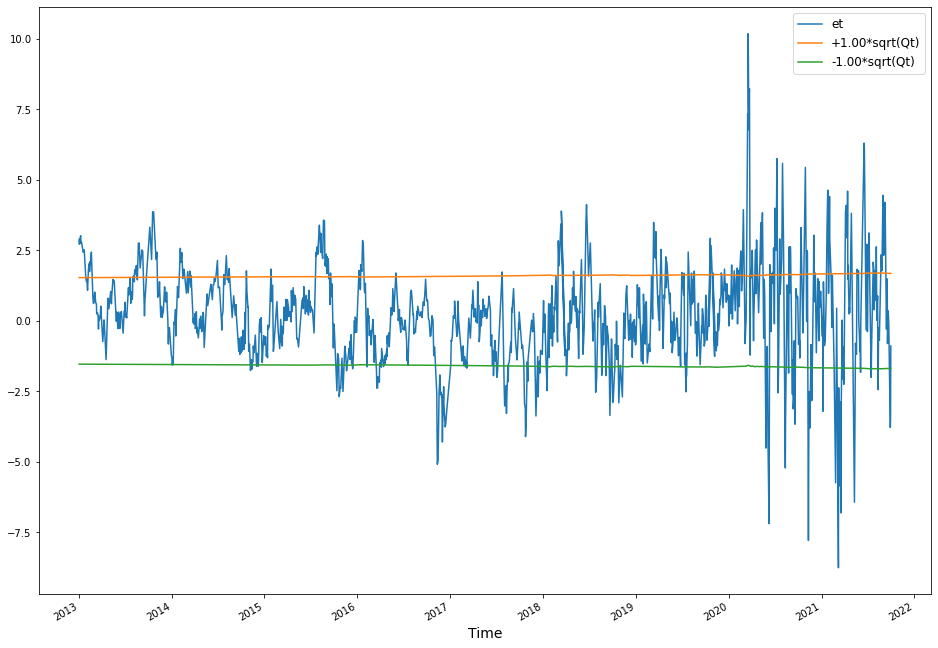

In [26]:
plt.figure(figsize = (16,12))
ax = plt.gca()
df_kpts_2013_2021.plot(kind='line', y='et', use_index=True, ax=ax)
df_kpts_2013_2021.plot(kind='line', y='Qt_sq', use_index=True, ax=ax)
df_kpts_2013_2021.plot(kind='line', y='Qt_sq_neg', use_index=True, ax=ax)
plt.legend(['et', f'+{kpts.delta:.2f}*sqrt(Qt)', f'-{kpts.delta:.2f}*sqrt(Qt)'], fontsize=12)
plt.xlabel('Time', fontsize=14)
plt.show()

In [27]:
class StrategyManager:
    def __init__(self, indepstk, depstk, balance_init=pow(10, 5), \
                 qty_target=200, ir=0.00013, lr=0.0005, delta=1., gamma=1.5):
        self.indepstk = indepstk
        self.depstk = depstk
        
        self.E = balance_init
        self.E_hist = [ self.E, ]
        
        self.qty_target = qty_target
        self.interest_rate = ir
        self.loss_rate = lr
        self.delta = delta
        self.gamma = gamma
        
        # Setup
        path_indepstk = f"./{self.indepstk}.US.csv"
        path_depstk = f"./{self.depstk}.US.csv"
        col_rename_table = {
            'Open': 'O',
            'High': 'H',
            'Low': 'L',
            'Close': 'C',
            'Adjusted_close': 'AC',
            'Volume': 'V'
        }
        
        self.df_indepstk = pd.read_csv(path_indepstk, index_col='Date')
        self.df_depstk = pd.read_csv(path_depstk, index_col='Date')
        self.df_indepstk.rename(columns=col_rename_table, inplace=True)
        self.df_depstk.rename(columns=col_rename_table, inplace=True)
        
        assert(len(self.df_indepstk) == len(self.df_depstk))
        
        self.df_AC = pd.DataFrame(
            {
                self.indepstk: self.df_indepstk['AC'],
                self.depstk: self.df_depstk['AC']
            }
        )
        self.df_AC.index = pd.to_datetime(self.df_AC.index)
        self.df_train = None
        self.df_test = None
        
        self.kpts = None
        self.pos_hist = []
        
    def train(self, start_date, end_date, ws=365, verbose=True):
        assert(isinstance(start_date, str))
        assert(isinstance(end_date, str))
        assert(end_date > start_date)
        assert(isinstance(ws, int))
        assert(ws > 0)
        
        self.df_train = self.df_AC[start_date:end_date]
        
        assert(ws < len(self.df_train))
        
        coefs = []
        for i in range(ws, len(self.df_train)):
            xs = self.df_train[self.indepstk].values[i-ws:i]
            ys = self.df_train[self.depstk].values[i-ws:i]
            coefs.append(regress_OLS(xs, ys).tolist())
        coefs = np.array(coefs, dtype=float)
                
        smf_model = smf.ols(f"{self.depstk}~{self.indepstk}", data=self.df_train).fit()
        if verbose:
            print(smf_model.summary())
        
        # W: 2x2
        W0 = np.cov(np.diff(coefs, axis=0).T)
        # V: scalar
        V0 = float(np.cov(smf_model.resid))
        # theta: 1x2
        theta0 = smf_model.params.values
        # R: 2x2
        R0 = smf_model.cov_params().values
        
        if verbose:
            print()
            print("Training Complete")
            print(f"{'='*80}")
            print("W0=")
            print(W0)
            print()
            print(f"V0={V0}")
            print()
            print("theta0=")
            print(theta0)
            print()
            print("R0=")
            print(R0)
            print()
        
        self.kpts = KPTStrategy((self.indepstk, self.depstk), self.qty_target, delta=self.delta, \
                                gamma=self.gamma, Wt_init=W0, Vt_init=V0, theta_init=theta0, Rt_init=R0)

    def backtest(self, start_date, end_date=None, verbose=True):
        assert(self.kpts is not None)
        assert(isinstance(start_date, str))
        if end_date is not None:
            assert(isinstance(end_date, str))
            assert(end_date > start_date)
        
        if end_date is None:
            self.df_test = self.df_AC[start_date:]
        else:
            self.df_test = self.df_AC[start_date:end_date]
        
        p_indep_prev, p_dep_prev = None, None
        q_indep_prev, q_dep_prev = None, None
        for d in self.df_test.index:
            pos_indep, pos_dep = self.kpts.get_position()
            
            p_indep, p_dep = self.df_test[self.indepstk][d], self.df_test[self.depstk][d]
            q_indep, q_dep = p_indep*pos_indep, p_dep*pos_dep
            
            self.kpts.process(StockEvent(self.indepstk, d, p_indep), verbose=verbose)
            self.kpts.process(StockEvent(self.depstk, d, p_dep), verbose=verbose)
            self.pos_hist.append(self.kpts.get_position())
            
            if d != self.df_test.index[0]:
                ret_indep, ret_dep = (p_indep/p_indep_prev-1), (p_dep/p_dep_prev-1)
                
                self.E = self.E + self.E * self.interest_rate \
                    + q_indep_prev * ret_indep + q_dep_prev * ret_dep \
                    + (q_indep_prev + q_dep_prev) * self.interest_rate \
                    - (np.abs(q_indep - q_indep_prev) + np.abs(q_dep - q_dep_prev)) * self.loss_rate
                
                self.E_hist.append(self.E)

            p_indep_prev, p_dep_prev = p_indep, p_dep
            q_indep_prev, q_dep_prev = q_indep, q_dep
    
    def annualized_return(self):
        ndays = len(self.E_hist) - 1
        return ((self.E_hist[-1]/self.E_hist[0])**(1/ndays))**(252)-1
    
    def sharpe_ratio(self, rf_rate=0.00013):
        Es = np.array(self.E_hist, dtype=float)
        rets = np.diff(Es) / Es[:-1]
        return (rets.mean() - rf_rate) / rets.std()
    
    def plot_signal(self, figsize=(16, 8)):
        df_signal = pd.DataFrame(nt_array_to_dict(self.kpts.dvt_hist))
        df_signal.set_index('time', inplace=True)
        df_signal['Qt_sq_neg'] = -df_signal['Qt_sq']
        df_signal['gamma_Qt_sq'] = self.gamma * df_signal['Qt_sq']
        df_signal['gamma_Qt_sq_neg'] = -self.gamma * df_signal['Qt_sq']
        
        plt.figure(figsize=figsize)
        ax = plt.gca()
        
        df_signal.plot(kind='line', y='et', use_index=True, ax=ax)
        df_signal.plot(kind='line', y='Qt_sq', use_index=True, ax=ax)
        df_signal.plot(kind='line', y='Qt_sq_neg', use_index=True, ax=ax)
        df_signal.plot(kind='line', y='gamma_Qt_sq', use_index=True, ax=ax)
        df_signal.plot(kind='line', y='gamma_Qt_sq_neg', use_index=True, ax=ax)
        
        plt.title(f'KPTS et Movement ({self.depstk}~{self.indepstk})', fontsize=20)
        plt.xlabel('Time', fontsize=14)
        plt.ylabel('Forecast error', fontsize=14)
        plt.legend(['$e_{t}$', f'{self.kpts.delta:.2f}*' + 'sqrt($Q_{t}$)', \
                    f'-{self.kpts.delta:.2f}*' + 'sqrt($Q_{t}$)', \
                    f'{self.kpts.gamma*self.kpts.delta:.2f}*' + 'sqrt($Q_{t}$)', \
                    f'-{self.kpts.gamma*self.kpts.delta:.2f}*' + 'sqrt($Q_{t}$)'], fontsize=14)
        
        plt.show()
        
    def plot_equity(self, figsize=(16, 8)):
        df_equity = pd.DataFrame(
            {
                'time': self.df_test.index,
                'E': self.E_hist
            }
        )
        df_equity.set_index('time', inplace=True)
        
        plt.figure(figsize=figsize)
        ax = plt.gca()
        
        df_equity.plot(kind='line', y='E', use_index=True, ax=ax)
        
        plt.title(f'KPTS Equity Movement ({self.depstk}~{self.indepstk})', fontsize=20)
        plt.xlabel('Time', fontsize=14)
        plt.ylabel('Equity ($)', fontsize=14)
        plt.legend(['Equity',], fontsize=14)
        
        plt.show()
        
    def plot_pnl(self, figsize=(16, 8)):
        df_pnl = pd.DataFrame(
            {
                'time': self.df_test.index,
                'E': self.E_hist
            }
        )
        df_pnl.set_index('time', inplace=True)
        df_pnl['pnl'] = df_pnl['E'].shift(1) - df_pnl['E']
        df_pnl['pnl'][0] = 0
        df_pnl.drop(columns=['E',], inplace=True)
        
        plt.figure(figsize=figsize)
        ax = plt.gca()
        
        df_pnl.plot(kind='line', y='pnl', use_index=True, ax=ax)
        
        plt.title(f'KPTS P&L Movement ({self.depstk}~{self.indepstk})', fontsize=20)
        plt.xlabel('Time', fontsize=14)
        plt.ylabel('P&L ($)', fontsize=14)
        plt.legend(['P&L',], fontsize=14)
        
        plt.show()
        
    def plot_position(self, figsize=(16, 8)):
        pos_hist_np = np.array(self.pos_hist, dtype=float)
        
        df_pos = pd.DataFrame(
            {
                'time': self.df_test.index,
                f'{self.indepstk}': pos_hist_np[:,0],
                f'{self.depstk}': pos_hist_np[:,1]
            }
        )
        
        df_pos.set_index('time', inplace=True)
        
        plt.figure(figsize=figsize)
        ax = plt.gca()
        
        df_pos.plot(kind='line', y=f'{self.indepstk}', use_index=True, ax=ax)
        df_pos.plot(kind='line', y=f'{self.depstk}', use_index=True, ax=ax, alpha=0.6)
        
        plt.title(f'KPTS Position Movement ({self.depstk}~{self.indepstk})', fontsize=20)
        plt.xlabel('Time', fontsize=14)
        plt.ylabel('Position (shares)', fontsize=14)
        plt.legend([f'{self.indepstk}', f'{self.depstk}'], fontsize=14)
        
        plt.show()

## Backtest

### SPY~DIA

In [28]:
stmgr_DIA_SPY = StrategyManager('DIA', 'SPY', delta=1.5)
stmgr_DIA_SPY.train('2010-01-01', '2013-01-01', verbose=False)
stmgr_DIA_SPY.backtest('2013-01-01', verbose=False)

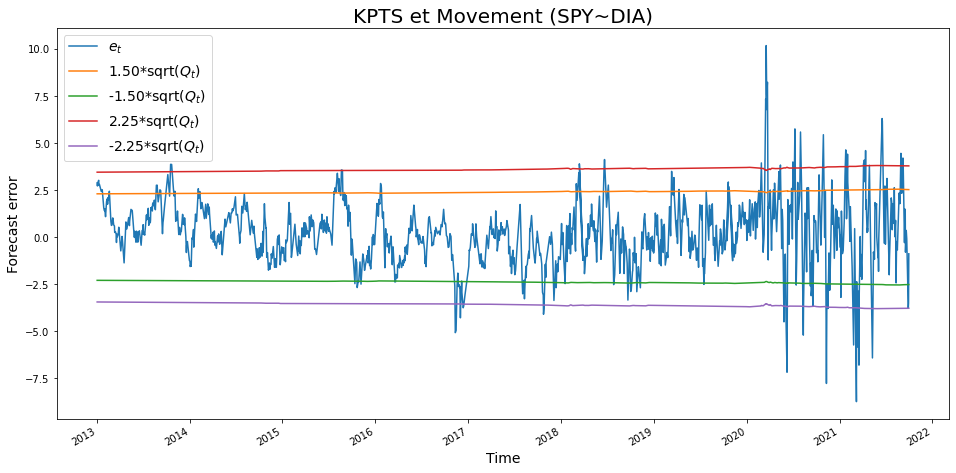

In [29]:
stmgr_DIA_SPY.plot_signal()

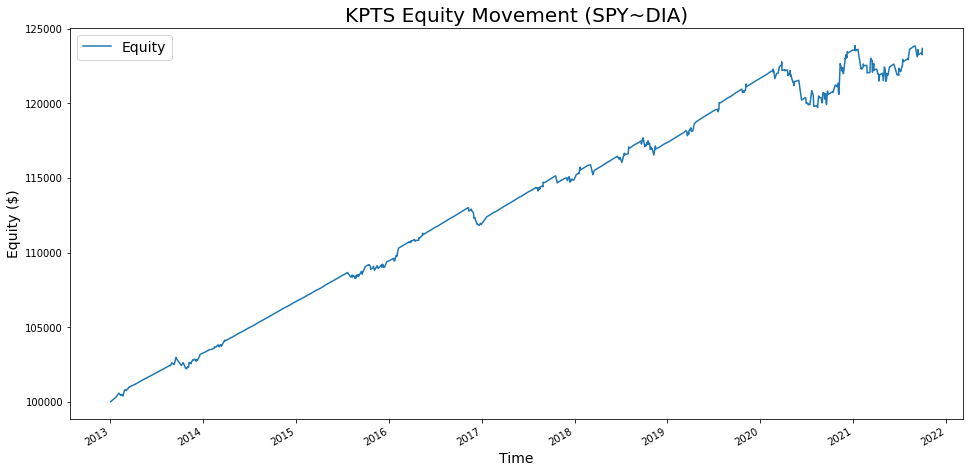

In [30]:
stmgr_DIA_SPY.plot_equity()

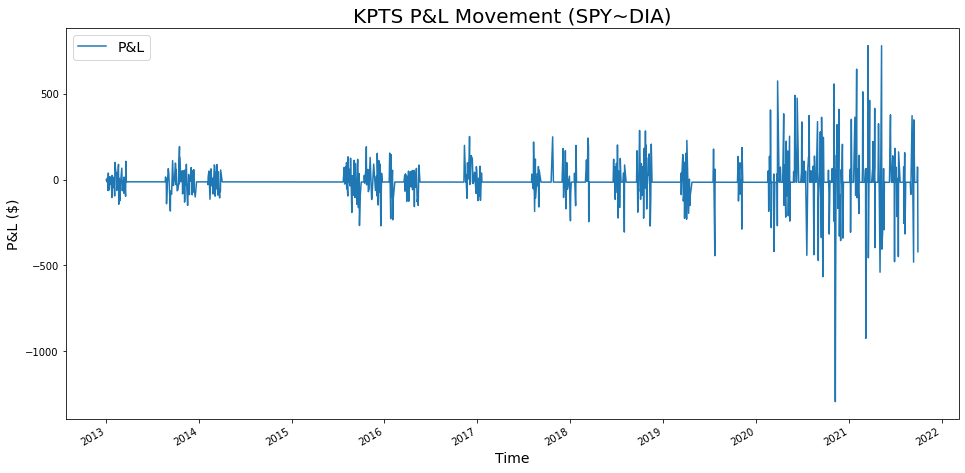

In [31]:
stmgr_DIA_SPY.plot_pnl()

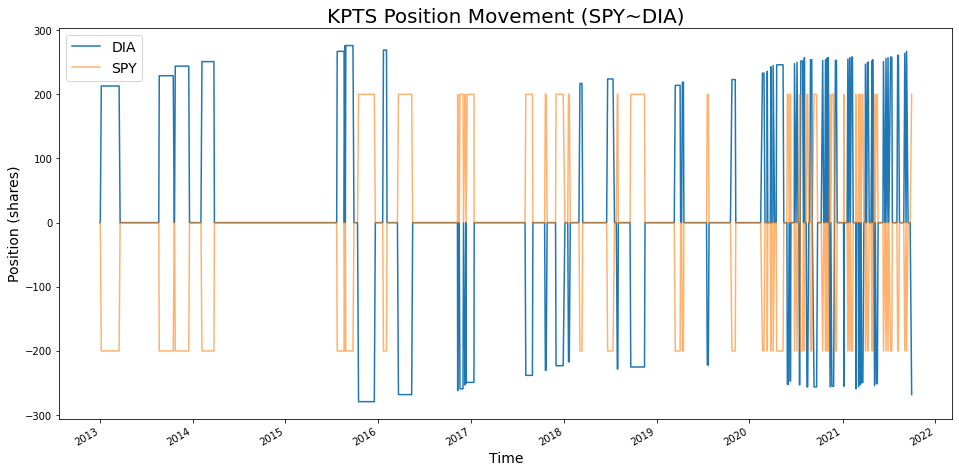

In [32]:
stmgr_DIA_SPY.plot_position()

In [33]:
stmgr_DIA_SPY.annualized_return()

0.02462290992255234

In [34]:
stmgr_DIA_SPY.sharpe_ratio()

-0.04187865673110753

In [35]:
stmgr_DIA_SPY.kpts.event_queue.qsize()

294

### SPY~IBM

In [36]:
stmgr_IBM_SPY = StrategyManager('IBM', 'SPY', delta=1.5)
stmgr_IBM_SPY.train('2010-01-01', '2013-01-01', verbose=False)
stmgr_IBM_SPY.backtest('2013-01-01', verbose=False)

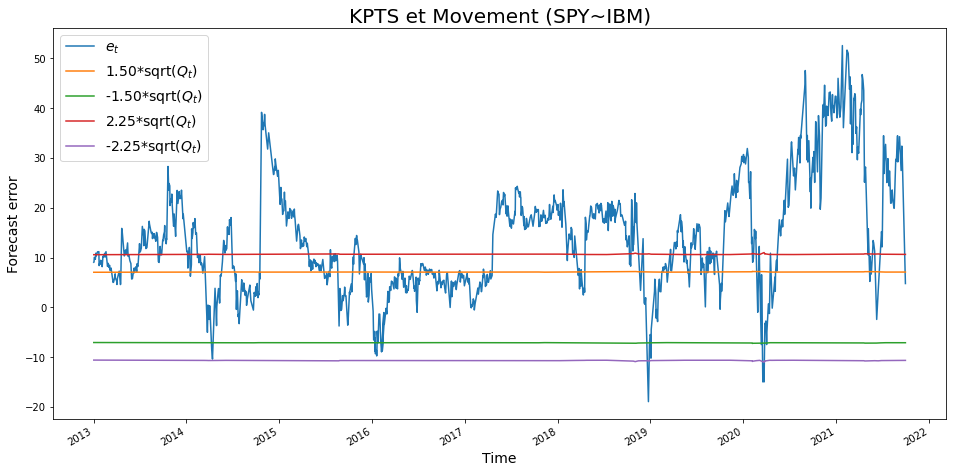

In [37]:
stmgr_IBM_SPY.plot_signal()

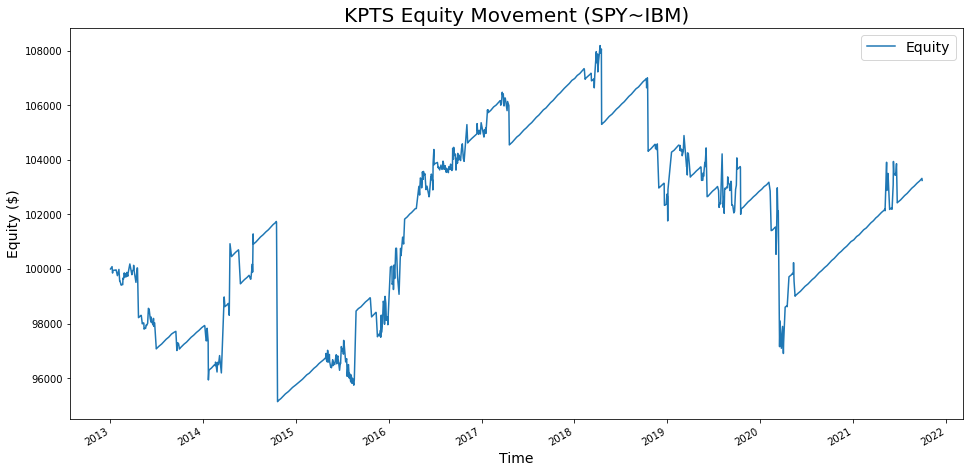

In [38]:
stmgr_IBM_SPY.plot_equity()

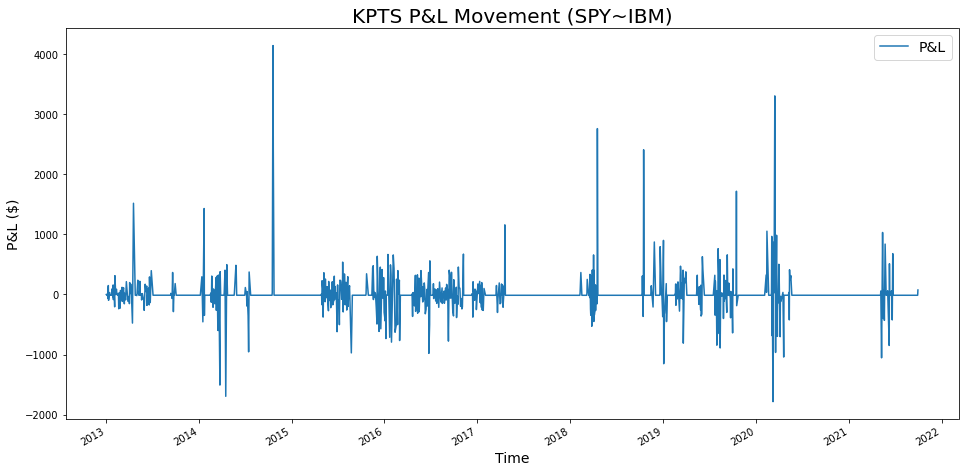

In [39]:
stmgr_IBM_SPY.plot_pnl()

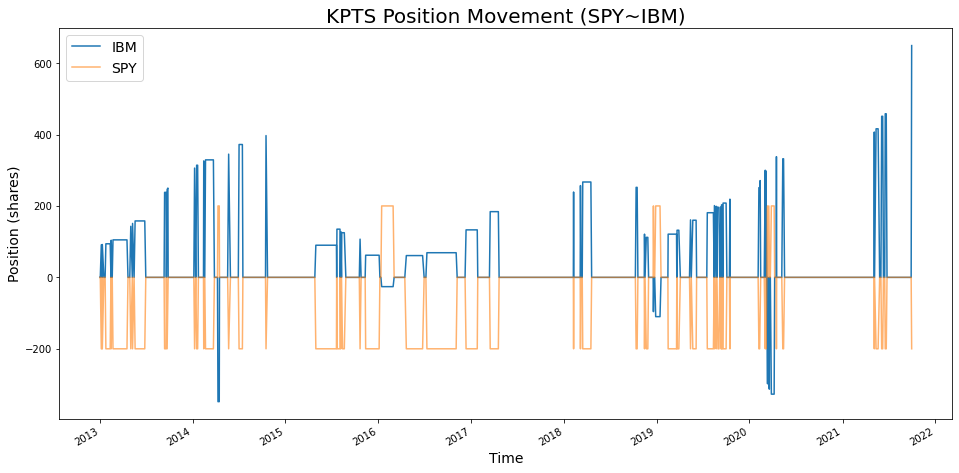

In [40]:
stmgr_IBM_SPY.plot_position()

In [41]:
stmgr_IBM_SPY.annualized_return()

0.003660097560736375

In [42]:
stmgr_IBM_SPY.sharpe_ratio()

-0.04731934980933049

In [43]:
stmgr_IBM_SPY.kpts.event_queue.qsize()

270

### AAPL~GOOG

In [44]:
stmgr_GOOG_AAPL = StrategyManager('GOOG', 'AAPL', delta=1.5)
stmgr_GOOG_AAPL.train('2010-01-01', '2013-01-01', verbose=False)
stmgr_GOOG_AAPL.backtest('2013-01-01', verbose=False)

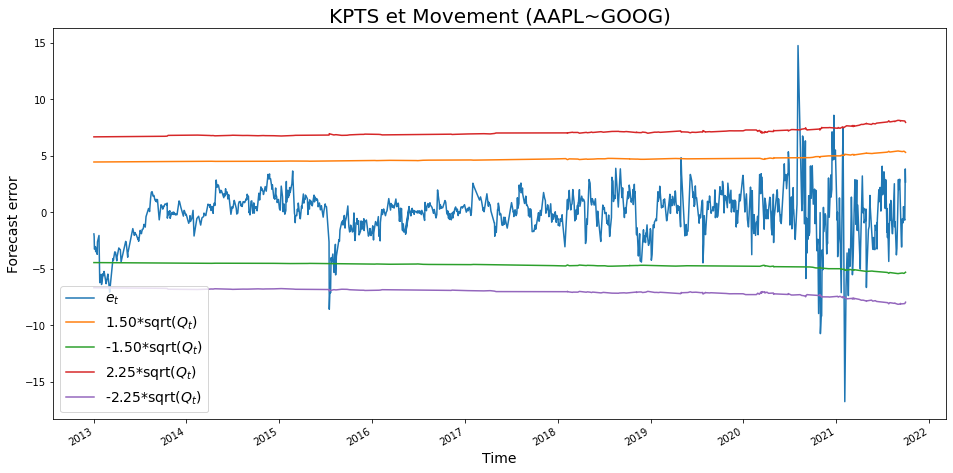

In [45]:
stmgr_GOOG_AAPL.plot_signal()

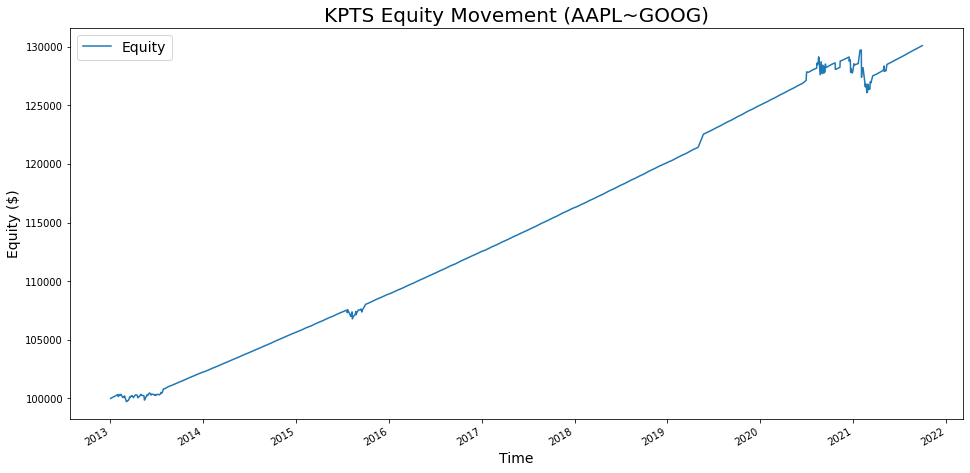

In [46]:
stmgr_GOOG_AAPL.plot_equity()

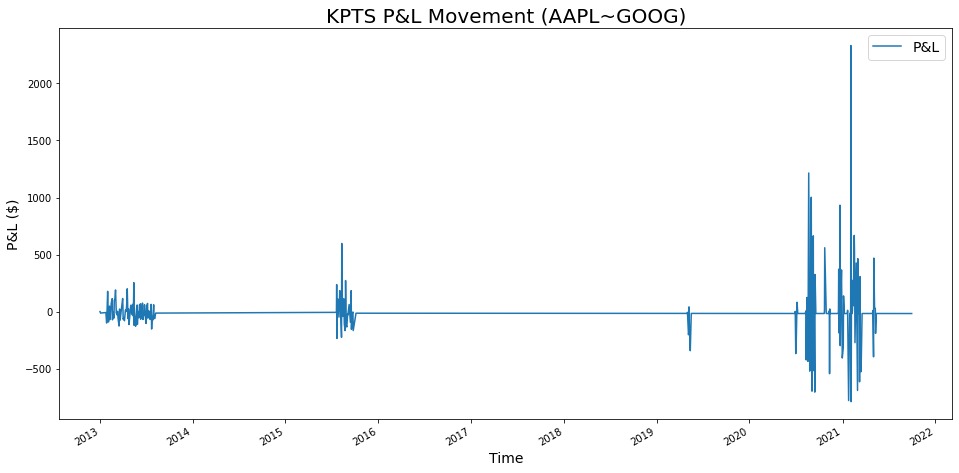

In [47]:
stmgr_GOOG_AAPL.plot_pnl()

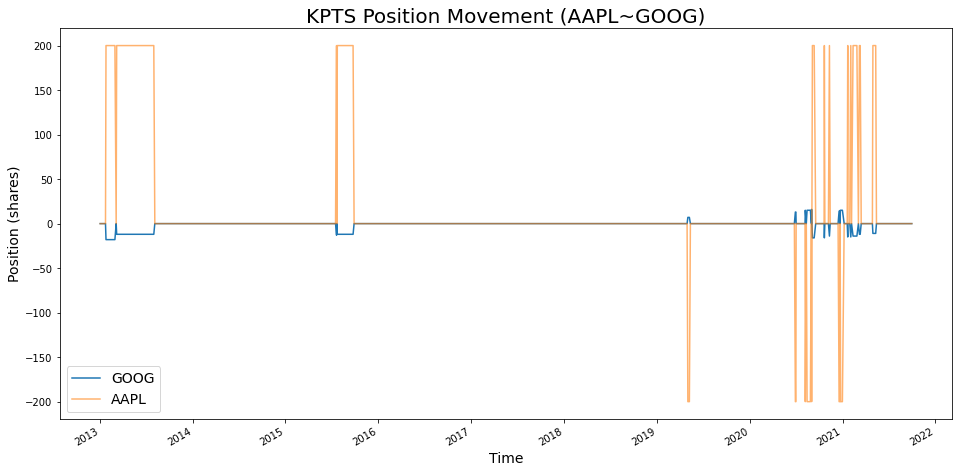

In [48]:
stmgr_GOOG_AAPL.plot_position()

In [49]:
stmgr_GOOG_AAPL.annualized_return()

0.03057849892772091

In [50]:
stmgr_GOOG_AAPL.sharpe_ratio()

-0.013541908998558665

In [51]:
stmgr_GOOG_AAPL.kpts.event_queue.qsize()

76